# Validation and mapping of hydrogens
This notebook reads in a CSV of mapped reactions, validates the mapping of heavy atoms, and then assigns atom maps to hydrogen atoms.  The original 'mapped' field of the CSV is replaced by the modified SMILES, and the resulting CSV is automatically downloaded.

The business logic portion of this notebook is the function 'validate_and_modify_smiles'. The algorithm assigns atom maps to hydrogens by first giving each hydrogen in the reactants a unique atom map number based on the heavy atoms they are bonded to, recording this in a dictionary. When processing the products, it uses this dictionary to match product hydrogens with reactant hydrogens, assigning the same atom map number to matched hydrogens. Unmatched product hydrogens receive an atom map of 0, indicating they are new. Similarly, reactant hydrogens that do not match any product hydrogens have their atom maps reset to 0, indicating their removal or transformation. This process ensures that hydrogens are consistently tracked across the reaction, accurately reflecting their presence and changes.

In [ ]:
%%capture
import gzip
from google.colab import files
import requests
import os
import io
import copy
import pandas as pd
from PIL import Image
from IPython.display import display
import matplotlib.pyplot as plt

# Download the file
url = "https://github.com/hesther/enzymemap/blob/main/data/processed_reactions.csv.gz?raw=true"
r = requests.get(url)
with open("processed_reactions.csv.gz", "wb") as f:
    f.write(r.content)

# Decompress the file
with gzip.open("processed_reactions.csv.gz", "rt") as f_in:
    with open("processed_reactions.csv", "wt") as f_out:
        f_out.write(f_in.read())

# Install RDKit
!pip install rdkit-pypi
from rdkit import Chem
from rdkit.Chem import AllChem, Draw
from rdkit.Chem.Draw import rdMolDraw2D

In [ ]:
def validate_and_modify_smiles(smiles: str) -> str:
    """
    This function takes a SMILES string representing a chemical reaction,
    validates and modifies it by adding explicit hydrogens, and ensures that
    all atoms, including most hydrogens, have unique and valid atom maps.

    Steps:
    1. Parse the SMILES string into a reaction object.
    2. Add explicit hydrogens to all reactants and products.
    3. Create a new reaction object with the added hydrogens.
    4. Validate that all heavy atoms have unique and valid atom maps.
    5. Ensure that atom maps are consistent between reactants and products.
    6. Assign atom maps to hydrogens, maintaining consistency.
    7. Convert the modified reaction back to a SMILES string.
    8. Return the modified SMILES string along with the original and modified reaction objects.
    """

    # Read the reaction SMILES and convert to a mol object
    try:
        raw_rxn = AllChem.ReactionFromSmarts(smiles, useSmiles=True)  # as smiles
        # print("Reaction successfully parsed.")
    except Exception as e:
        raise ValueError(f"Invalid reaction SMILES: {smiles}") from e

    # Add explicit hydrogens to all reactants and products
    new_reactants = []
    for reactant in raw_rxn.GetReactants():
        reactant_with_h = Chem.AddHs(reactant)
        new_reactants.append(reactant_with_h)

    new_products = []
    for product in raw_rxn.GetProducts():
        product_with_h = Chem.AddHs(product)
        new_products.append(product_with_h)

    # Create a new reaction with added hydrogens
    reaction = AllChem.ChemicalReaction()
    for reactant in new_reactants:
        reaction.AddReactantTemplate(reactant)
    for product in new_products:
        reaction.AddProductTemplate(product)

    # Make a duplicate of the original for output
    original_reaction = copy.deepcopy(reaction)

    # Validate atom maps
    def validate_atom_maps(mol):
        atom_map_set = set()
        for atom in mol.GetAtoms():
            if atom.GetAtomicNum() == 1:  # Skip hydrogen
                continue
            atom_map = atom.GetAtomMapNum()
            if atom_map <= 0:
                raise ValueError(f"Atom without valid map number: {atom.GetSymbol()} in {smiles}")
            if atom_map in atom_map_set:
                raise ValueError(f"Duplicate atom map number: {atom_map} in {smiles}")
            atom_map_set.add(atom_map)
        return atom_map_set

    reactants_atom_maps = set()
    products_atom_maps = set()

    for reactant in reaction.GetReactants():
        reactants_atom_maps.update(validate_atom_maps(reactant))
        # print(f"Reactants atom maps: {reactants_atom_maps}")

    for product in reaction.GetProducts():
        products_atom_maps.update(validate_atom_maps(product))
        # print(f"Products atom maps: {products_atom_maps}")

    if reactants_atom_maps != products_atom_maps:
        raise ValueError(f"Mismatch between reactant and product atom maps in {smiles}")

    # Add atom maps to hydrogens
    next_atom_map = max(reactants_atom_maps.union(products_atom_maps)) + 1
    hydrogen_map_dict = {}
    # print(f"Initial next available atom map: {next_atom_map}")

    def add_hydrogen_maps(mol, is_reactant=True):
        nonlocal next_atom_map
        for atom in mol.GetAtoms():
            if atom.GetAtomicNum() == 1:  # Hydrogen
                for neighbor in atom.GetNeighbors():
                    neighbor_map = neighbor.GetAtomMapNum()
                    if neighbor_map > 0:
                        if is_reactant:
                            if neighbor_map not in hydrogen_map_dict:
                                hydrogen_map_dict[neighbor_map] = []
                            hydrogen_map_dict[neighbor_map].append(next_atom_map)
                            atom.SetAtomMapNum(next_atom_map)
                            # print(f"Assigned atom map {next_atom_map} to reactant hydrogen attached to atom map {neighbor_map}")
                            next_atom_map += 1
                        else:
                            if neighbor_map in hydrogen_map_dict and hydrogen_map_dict[neighbor_map]:
                                assigned_map = hydrogen_map_dict[neighbor_map].pop(0)
                                atom.SetAtomMapNum(assigned_map)
                                # print(f"Assigned atom map {assigned_map} to product hydrogen attached to atom map {neighbor_map}")
                            else:
                                atom.SetAtomMapNum(0)
                                # print(f"Assigned atom map 0 to product hydrogen attached to atom map {neighbor_map} (no matching reactant hydrogen)")

    for reactant in reaction.GetReactants():
        add_hydrogen_maps(reactant, is_reactant=True)

    for product in reaction.GetProducts():
        add_hydrogen_maps(product, is_reactant=False)

    for reactant in reaction.GetReactants():
        for atom in reactant.GetAtoms():
            if atom.GetAtomicNum() == 1 and atom.GetAtomMapNum() in [item for sublist in hydrogen_map_dict.values() for item in sublist]:
                atom.SetAtomMapNum(0)
                # print(f"Reverted reactant hydrogen atom map to 0 for atom index {atom.GetIdx()}")

    # Make a duplicate of the original for output
    h_mapped_reaction = copy.deepcopy(reaction)

    # Convert mol object back to SMIRKS string
    try:
        modified_smiles = AllChem.ReactionToSmarts(reaction)
    except Exception as e:
        raise ValueError(f"Error converting modified reaction to SMIRKS: {smiles}") from e

    return modified_smiles, original_reaction, h_mapped_reaction


Original SMARTS: [CH3:1][C:2](=[O:3])[O:4][CH3:5].[OH2:6]>>[CH3:1][C:2](=[O:3])[OH:6].[CH3:5][OH:4]
Output SMARTS: [#6:1](-[#6:2](=[#8:3])-[#8:4]-[#6:5](-[H:10])(-[H:11])-[H:12])(-[H:7])(-[H:8])-[H:9].[#8:6](-[H:13])-[H]>>[#6:1](-[#6:2](=[#8:3])-[#8:6]-[H:13])(-[H:7])(-[H:8])-[H:9].[#6:5](-[#8:4]-[H])(-[H:10])(-[H:11])-[H:12]


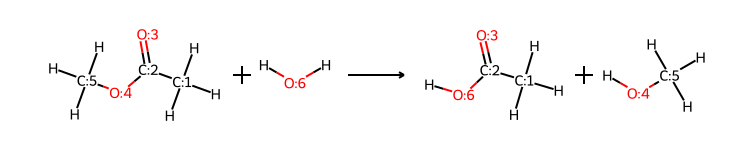

In [ ]:
"""
Tests the `validate_and_modify_smiles` function on a specific
chemical reaction (an esterase reaction). It performs the following steps:

1. Defines a SMILES string representing the esterase reaction.
2. Converts the SMILES string into a reaction object.
3. Calls the `validate_and_modify_smiles` function to validate and modify the reaction.
4. Prints the original and modified SMILES strings.
5. Displays the original reaction object.
"""

smiles = "[CH3:1][C:2](=[O:3])[O:4][CH3:5].[OH2:6]>>[CH3:1][C:2](=[O:3])[OH:6].[CH3:5][OH:4]"
reaction = AllChem.ReactionFromSmarts(smiles, useSmiles=True)
modified_smiles, original_reaction, h_mapped_reaction = validate_and_modify_smiles(smiles)

print(f"Original SMARTS: {smiles}")
print(f"Output SMARTS: {modified_smiles}")

# Display the original reaction
original_reaction


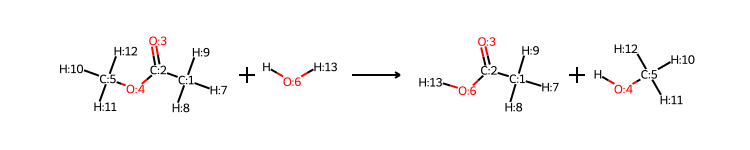

In [ ]:
"""
Display the hydrogen-mapped reaction object generated from the
`validate_and_modify_smiles` function.
"""
h_mapped_reaction

In [ ]:
"""
Reads the CSV file containing reaction SMILES, processes each line to validate and modify the SMILES strings,
and saves the revised data to a new CSV file.
"""
# Read the CSV file
df = pd.read_csv("processed_reactions.csv")

# Initialize counters
error_count = 0
success_count = 0

# Process the entire file
for index, row in df.iterrows():
    try:
        smiles = row['mapped']
        new_smiles, original_reaction, h_mapped_reaction = validate_and_modify_smiles(smiles)
        df.at[index, 'mapped'] = new_smiles
        success_count += 1
    except Exception as e:
        print(f"Error processing reaction at index {index}: {e}")
        error_count += 1
        df.at[index, 'mapped'] = None

# Save the revised DataFrame to a new CSV file
output_filename = "hydrogen_mapped_reactions.csv"
df.to_csv(output_filename, index=False)

# Print the error count
print(f"Number of reactions successfully converted: {success_count}")
print(f"Number of reactions with errors: {error_count}")

# Download the revised file
files.download(output_filename)


Number of reactions successfully converted: 349458
Number of reactions with errors: 0


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

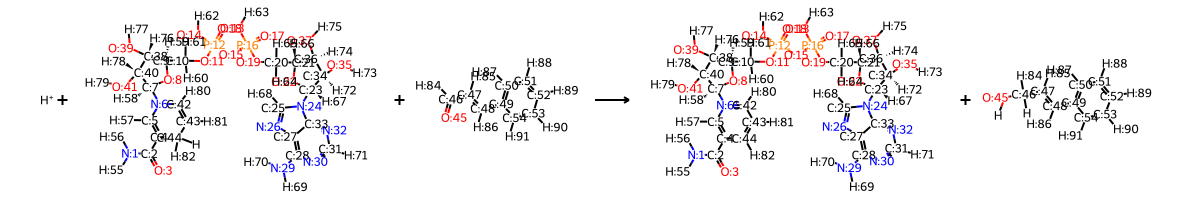

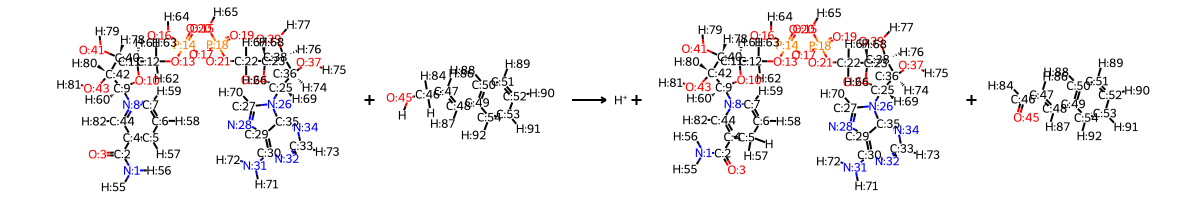

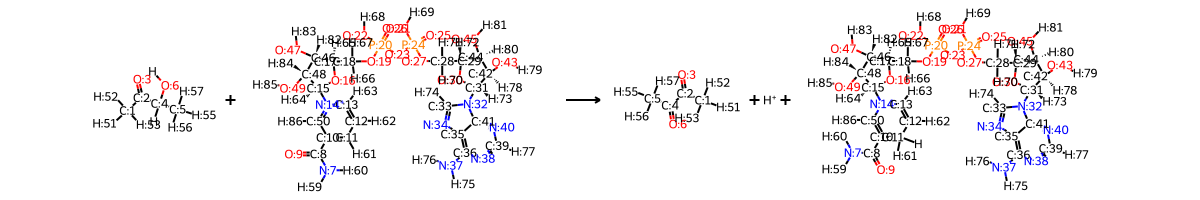

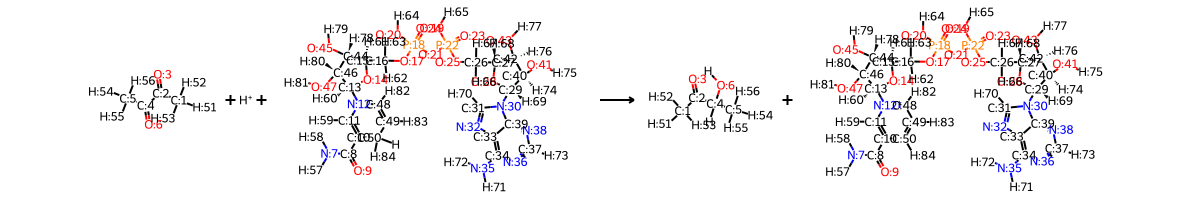

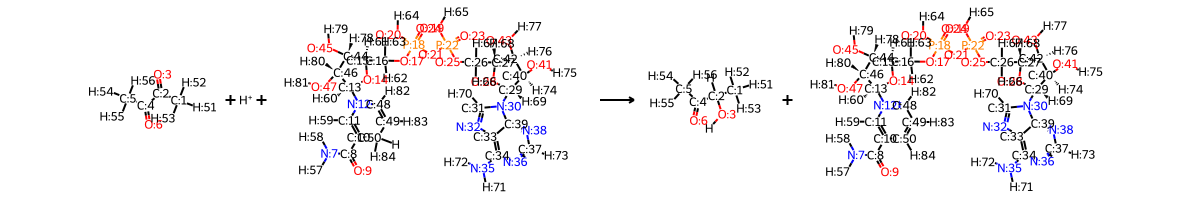

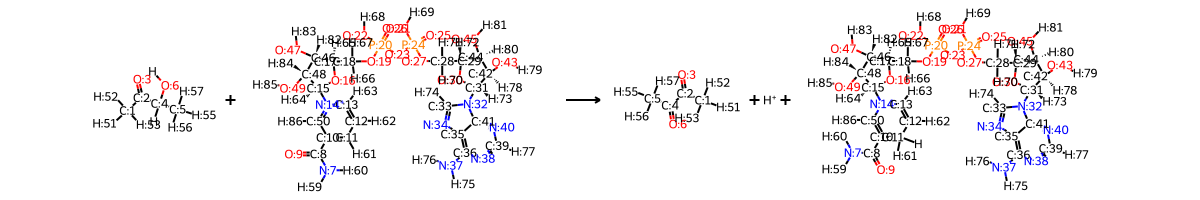

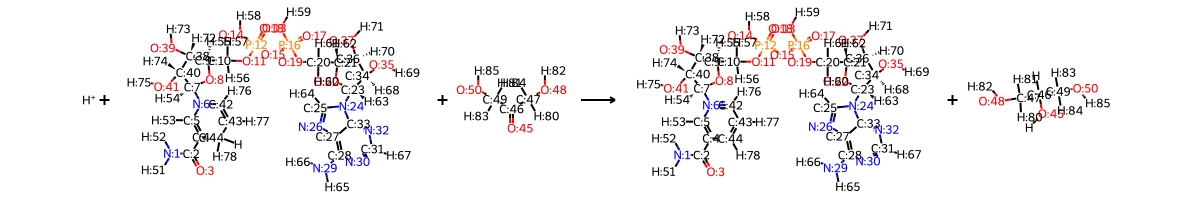

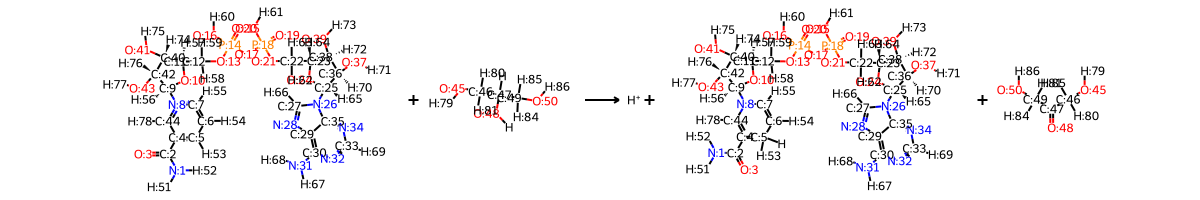

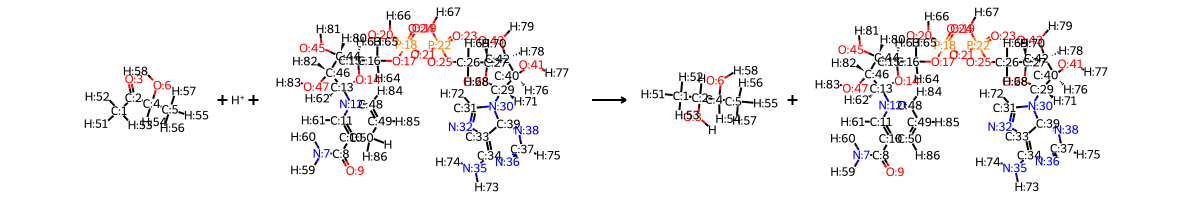

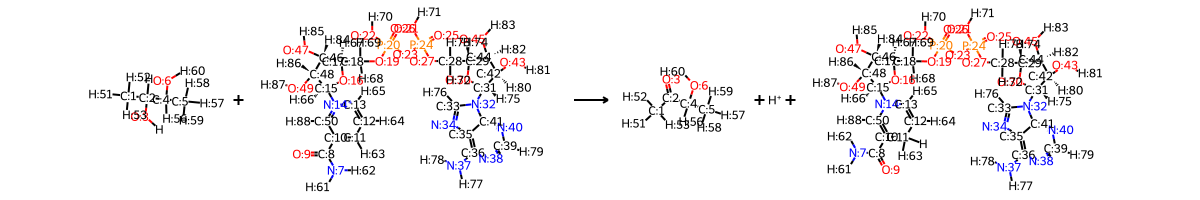

In [ ]:
# Read the CSV file
df = pd.read_csv(output_filename)

# Display 10 reactions for illustration
for index, row in df.iloc[707:717].iterrows():
    try:
        smiles = row['mapped']  # Assuming 'mapped' is the column name for the SMILES strings
        reaction = AllChem.ReactionFromSmarts(smiles, useSmiles=True)

        # Generate image
        img = Draw.ReactionToImage(reaction)

        # Display image
        display(img)

        # Save image to file for reference
        img.save(f"reaction_{index}.png")

    except Exception as e:
        print(f"Error processing reaction at index {index}: {e}")
